# Panic selling simulation

## Experiment Design

- Two ways of starting panic selling: 1) random trigger (mimicing incidents outside of the market, like rumors) 2) triggered by market indicators (for now, price drop at a critical magnitude; in the future, other indicators like net transaction volume could be included too)

[ ] does this assumption make sense? or we can just totally leave it to randomness?
- The behavior of panic selling: 
   - There will be conditional selling for the system which means that at each timestep, there is the possibility that for any reason some participants might sell if the price drop reaches certain level.
    - More formally, there will be a distribution $\Delta P$ of the price change at which a sell might occur, and a distribution N for the size of the sell at that epoch if the price change is at certain magnitude. So, if the current price < sample drawn from P, a sell amount drawn randomly from distribution N is put into the system.
- We expect to see:
    - If there's no RBS, we will see the panic selling being initiated and snowballing until it depletes the pool.
    - If the RBS is stabilizing enough, the panic selling should subside and the system will get back to equilibrium. We will explore different parameters to see when that could happen and when there could be a death spiral of selling.

## Parameter Sweep

The following will be the different parameter sweep variables to test:
1. Initial panic selling magnitude
2. The price to sell distribution, P
3. The amount to sell distribution, N
4. Parameterization of the RBS

### Success Metrics/KPIs

KPIs:
1. Ending Price
2. Time to return to equilibrium: The time it takes before the system stabilizes (if it does) and is trading in equilibrium
3. Number of Interventions: The number of times the RBS had to intervene to stabilize
4. Reserves Used: The amount of reserves used by the RBS

Success Metrics:
1. Returned to Equilibrium: Whether the system returned to the equilibrium state
2. Time to Equilibrium Minimal: A boolean of whether the system stabilized before some C number of timesteps 
3. Minimal Interventions: A boolean of whether there was only 1 or some C number of interventions before the system reached equilibrium againstem 


In [1]:
from IPython.display import display
from model.utility.default_parameters import default_params_soros as params
from model.utility.default_initial_state import default_initial_soros as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run, post_processing


In [7]:
initial_state = fill_in_initial_state(initial_state, params)

initial_state

{'liq_stables': 21000000,
 'reserves_stables': 170000000,
 'reserves_volatile': 25000000,
 'price': 9.5,
 'reward_rate': 0.000198,
 'market_demand_supply': MarketDemandSupply(total_supply=0.001, total_demand=-0.008),
 'target_liq_ratio_reached': False,
 'reserves_in': 0,
 'supply': 25000000,
 'ma_target': 9.5,
 'ask_change_ohm': 0,
 'bid_change_ohm': 0,
 'net_flow': None,
 'bid_capacity_target': 16150000.0,
 'ask_capacity_target': 1921739.1304347825,
 'bid_capacity_target_cushion': 4966125.0,
 'ask_capacity_target_cushion': 590934.7826086956,
 'natural_price': None,
 'bid_capacity_cushion': 4966125.0,
 'ask_capacity_cushion': 590934.7826086956,
 'bid_change_cushion_usd': None,
 'bid_change_cushion_ohm': None,
 'ask_change_cushion_usd': None,
 'ask_change_cushion_ohm': None,
 'bid_change_usd': None,
 'ask_change_usd': None,
 'reserves_out': None,
 'ohm_traded': None,
 'cum_ohm_purchased': 0,
 'cum_ohm_burnt': 0,
 'cum_ohm_minted': 0,
 'cum_ohm_minted_forbond': 0,
 'cum_ohm_burned_frombo

In [11]:
initial_state['liq_ohm']
# hmmm? protocol owned stability? 

2210526.3157894737

## first, show the panic sell distribution

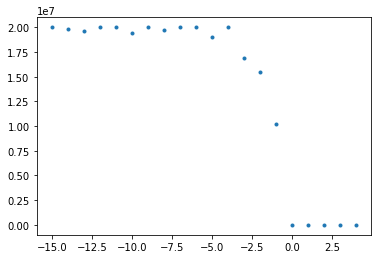

In [5]:
import numpy as np
def sellamount(price_change,liq_ohm,k=0.7,sigma=.05):
    # given the price change, how much sell will happen
    # k is the factor adjusting the curve shape, ranging (0,+inf)
    # TODO: in the future, allow different shapes of this curve (e.g. sigmoid)
    if price_change>=0:
        return 0
    else:
        amount = liq_ohm*(1-np.exp(-k*np.abs(price_change)))
        # turn it into log normal distribution
        mu  = np.log(amount) + sigma ** 2 # so the mode for this random distribution is 
        rng = np.random.default_rng()
        randamount = rng.lognormal(mu, sigma, 1)[0]
        #randamount = np.random.lognormal(mu,sigma)
        if randamount > liq_ohm:
            randamount = liq_ohm
        return randamount
price_change_arr = np.arange(-15,5,1)
amount_arr = [sellamount(p,2e7) for p in price_change_arr]
from matplotlib import pyplot as plt
plt.plot(price_change_arr,amount_arr,'.')

# Run the simulation of panic sell: examples of that happening

Change of the code:
- add one part in the netflow that is related to the price change.

In [1]:
from model.utility.default_parameters import default_params1 as params
import pandas as pd
from model.signals.bond_signals import total_value_bond_creation
number_runs = 2
number_steps = 100


#params.update({'panic_sell_on':[True,False]})
params.update({'panic_sell_on':[True]})
params.update({'panic_param':[0.1,0.4,0.7]})
from model.utility.default_initial_state import default_initial_state1 as initial_state
# Fill in the initial state
from model.utility.initial_state_functions import fill_in_initial_state
initial_state = fill_in_initial_state(initial_state, params)

from model.run import load_config, run,new_run, post_processing
# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps)

# Run the experiment
raw = new_run(exp)

# Parse the raw data
df1 = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 24, 6, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 24, 6, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 22.34s


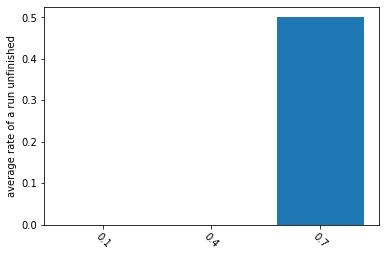

In [2]:
from model.utility.visualization import plot_simu_interruption_rate
plot_simu_interruption_rate(df1,number_steps,labels =[0.1,0.4,0.7])


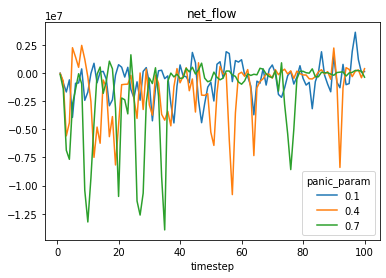

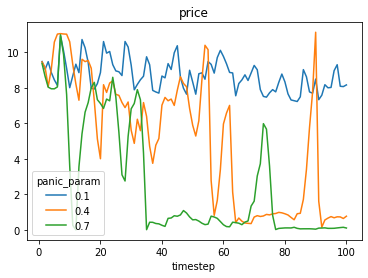

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [4]:
# Plot the average values for natural price by the groups of supply and demand factor
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

variables_to_plot = ["net_flow", "price"]
grouping_variables = ['panic_param']

plot_grouped_variables_average(variables_to_plot,grouping_variables,df1)